# Monitoring Water Quality - Aquatic Weeds and floating Algae

* **Data used:** 
- Geomedians from OLI, MSI, and TM
- Surface reflectance from OLI, MSI and TM
- Water observations from space, annual summaries

## Objective
The objective of this notebook is **to provide a *practical tool* to report on the coverage of aquatic weeds (water hyacinth) and algal blooms on specific water bodies**, which can be adapted, applied and improved. 

In order to be as realistic as possible, the notebook is longer than most, and involves more data preparation steps.

## Background
A widespread phenomenon on inland waters is the presence of either photsynthesising algae - cyanobacteria, and / or aquatic weeds such as Water Hyacinth (**https://www.arc.agric.za/arc-ppri/Pages/Water-hyacinth.aspx**). These can be monitored using DE Africa data and services, and published algorithms. Water Hyacinth is particularly reported to be a problem in rift valley lakes including parts of Lake Victoria such as around the Port of Kisumu, and is a well known problem on Hartbeespoort Dam in South Africa. 

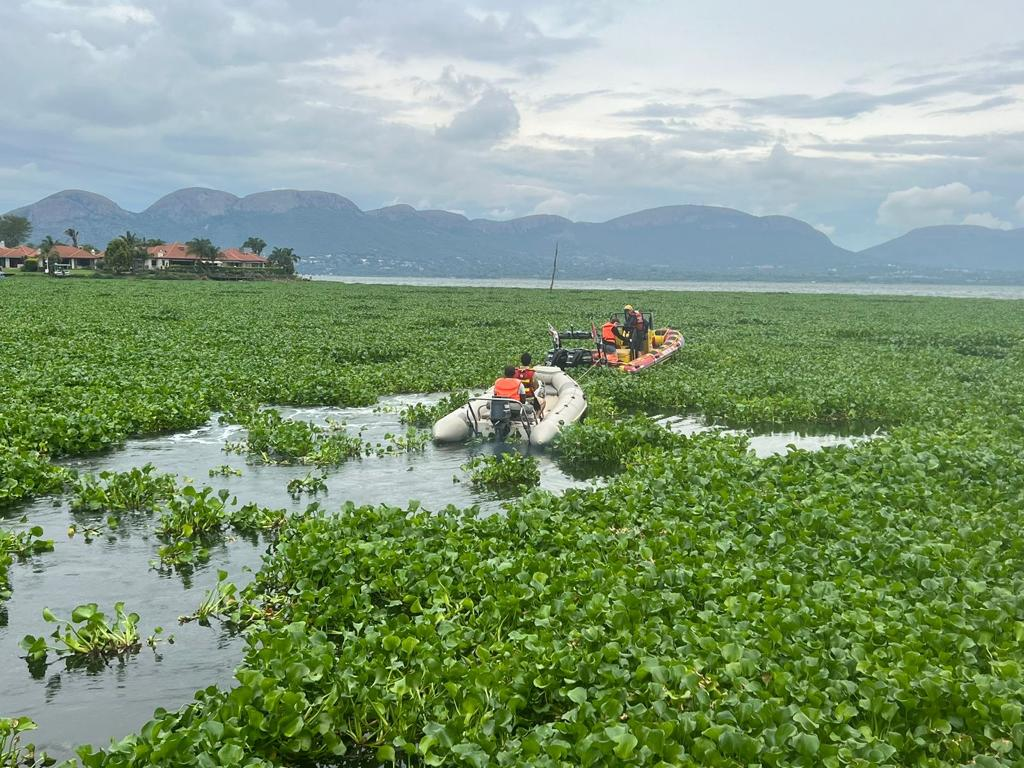
(**https://thebulrushes.com/2025/07/17/magalies-water-reduces-water-hyacinth-at-hartbeespoort-dam/**)

The **Floating Algal Index (FAI)** can be used to map and quantify the extent of these phenomena. The FAI is sensitive to photosynthetic surface material (PSM) on the water. FAI can be used with the Sentinel-MSI, Landsat-OLI and Landsat-TM instruments. Used together, the MSI and OLI sensors can provide over 100 observations each year, and the TM instrument provides continuity from the early 2000s. These observations, used in conjunction with DE Africa WOfS, Geomedians, and Waterbodies, can capture these dynamic processes and report on the percentage of area that they affect.  


### FAI
The FAI detects unexpectedly high values of near infra-red (NIR) reflectance, by comparing the NIR value reflectance with the value that would be expected given the Red, and short-wave infra-red (SWIR) reflectances. The approach takes into account the specific central wavelenghts of the sensor bands. This means that FAI is more able to support multi-sensor approaches than other measures and indices which assume identical sensor characteristics.  

The FAI is calculated by interpolating a value of the NIR band from the observed values of the Red and SWIR bands, and comparing this to the observed NIR band:

$$
InterpolatedNIR = Red + ( SWIR - Red ) * (NIR wavelength - Red wavelength)/(SWIR wavelength - Red wavelength)
$$
$$
FAI = ObservedNIR - InterpolatedNIR
$$

For the MSI sensor on the Sentinel-2 satellites, the bands (central wavelength) are listed as:
$$\text{Red wavelenth (msi band 4)} = 665   \text{ nm};  $$$$ \text{   NIR wavelenth (msi band 8a)} = 864 \text{ nm}; $$$$ \text{   SWIR wavelenth (msi band 11)} = 1612 \text{ nm}$$


Reference: **Hu, 2009, *A novel ocean color index to detect floating algae in the global oceans*** doi:10.1016/j.rse.2009.05.012

## Approach
This notebook aims to provide the foundation for a practical tool to monitor and visualise the extent of water hyacinth and cyanobacteria which produce photosynthetic material on the water surface and are often a problem. 

To do this:
1. We **choose a specific waterbody to measure**. At this time, we select a rectangle and all of the water inside of that rectangle is considered in the analysis. Further developments are anticipated to select a water polygon(s) based on the DE Africa Waterbodies service.
2. We **identify water areas for each year** using the DE Africa Water Observations from Space (WOfS). Water surfaces are constantly contracting and expanding through time. WOfS captures this variation as the frequency with which water is seen; the ''wofs_freq'' variable gives a statistical approach to defining areas of water. This allows for water often being 'hidden' beneath floating vegetation.
3. We **measure and report the area of water that is affected** using the Floating Algal Index (FAI) to identify areas of photosynthetic surface material (PSM) on the water surface.

### **Longer term patterns** (5 - 25 years) are analysed using the DE Africa geomedians
The first part of this workbook enables long-term assessment. 

For multi-year trends we apply the FAI to the DE Africa Geomedians. For any given year, DEA geomedians are produced for one or more of Landsat-TM (1990-2012), Landsat-OLI (2013-present) and Sentinel-MSI (2017-present). FAI for each year are based on all available geomedians. Geomedians capture the 'typical' state of the water during the year, so sesults from this level of analysis will detect areas and indicate years where PSM has been consistently observed during the year. 

### **Short term monitoring** (upto 3 years) calls for the source observational data
The second part of this workbook enables a more detailed analysis based on all the available surface reflectance data. This is optional, and should only be used for limited time-spans in order to stay within the memory limitations of the notebook.

For short-term monitoring we call on the full set of observations available in DE Africa from the TM, OLI and MSI sensors (this range could be increased in future). These sensors produce hundreds of observations each year. FAI for multiple sensors are compared to adjust biases, with the MSI based measurment taken as the baseline. Because aquatic weeds and algae are mobile and grow rapidly, measurements can vary rapidly day to day and week to week. This noise is smoothed with a moving average window spanning multiple observations, nominally 15. 

Analysis of hundreds of images at a time can rapdily overwhelm the memory allowance of a sandbox session. To avoid this, we down-sample the data, ensuring that we are still 'sampling' the waterbody with thousands of pixels at each time slice. 

To be confident of the results of the monitoring we compare with published material for Hartbeespoort dam in South Africa. Where results diverge we examine specific observations to confirm that the algorithms are reflecting the patterns visible in the day to day satellite images. 

### Outputs
Whilst images are used to *understand what the data are saying*, the **primary outputs** from the analyses are **statistics of affected areas**. 

### Processing steps in detail:
Several steps are involved, having chosen an area of interest:

  1. to determine actual areas of water, we access annual WOfS data for at least five years based on the time interval for analysis 
  2. we access the EO data from the data cube into two muli-sensor datasets, one **annual for geomedians**, one for **daily observations**
  3. we filter the observations on data quality, using the qa bands provided with the data
  4. we derive the FAI values for each pixel, and if necessary apply any adjustments to maximise comparability between sensor
  5. we apply a threshold on the FAI values to reteive areas of interest
  6. we calculate the proportion of the water area that is affected
  7. we produce a meaningful graph and summary report

The spatial resolution, or cell size, for the analysis is set to work within the memory limitations of the sandbox. *We can have an accurate result for a waterbody without using every pixel* 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd     
from odc.geo.geom import Geometry


from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs, wofs_fuser
from deafrica_tools.areaofinterest import define_area

In [3]:
import scipy as sp
from datetime import timedelta
import gc

### Select a location
The function below stores a dictionary of places. 

You can add to this or simply select a name from the list and run the function, or use the default.

The analysis runs on the area within the coordinates.

In [4]:
# the place and times of interest can be chosen from here -- other places can be added 
def set_place_and_time(placename='Hartbeespoort_dam',year1='2024-01-01',year2='2025-10-31'):
    places = {
        'Hartbeespoort_dam':   {"xyt" :{"x": (  27.7972, 27.91117), "y" : (-25.7761,-25.7275) ,"time": (year1,year2)},"desc": "Haartbeesport Dam  -- South Africa"},
        'Lake_Manyara':        {"xyt" :{"x": ( 35.724 ,  35.929 ), "y" : ( -03.814, -03.409), "time": (year1,year2) },"desc": "Lake_Manyara, Tanzania"          },#this is the lake to use as an example of monitoring, see 2015-12-28
        'Lake_Baringo'     :   {"xyt" :{"x": (36.00,  36.17),     "y": (00.45,00.74),        "time": (year1,year2)},"desc":'Lake Baringo'    },
        'Weija_Reservoir'  :   {"xyt" :{"x": (-0.325, -0.41),     "y": ( 5.54, 5.62),        "time": (year1,year2)  },"desc":''                },
        'Lake_Sulunga'     :   {"xyt" :{"x": (34.95, 35.4),       "y": (-6.3, -5.8),         "time": (year1,year2)  },"desc":""                },
        'cameroon_res1'    :   {"xyt" :{"y": (6.20,6.30),          "x": (11.25, 11.35),      "time": (year1,year2)  },"desc": "reservoir in cameroon"},
        'Lake_vic_algae':      {"xyt" :{"x": ( 34.62, 34.78),       "y" : ( -.18,-.08),      "time": (year1,year2)  },"desc": "Lake Victoria Water Hyacinth affected area in NE, port Kisumu"},
        'Ethiopia_Lake_Tana':  {"xyt" :{"x": ( 37.05,   37.22),    "y" : (  11.9  ,  12.0),  "time": (year1,year2)  },"desc": "Ethiopia_Lake_Tana"          },
        'Mare_aux_Vacoas':     {"xyt" :{"x": ( 57.485,  57.524),   "y" : ( -20.389, -20.359),"time": (year1,year2)  },"desc": "Mare_aux_Vacoas"          },
        'SA_smalldam':         {"xyt" :{"x": ( 19.494,  19.498),   "y" : ( -33.802, -33.800),"time": (year1,year2)  },"desc": "Irrigation Dam, South Africa"          },
        'Lake Chamo'   :       {"xyt" :{"x": ( 37.45,   37.65) ,   "y" : (   5.685 ,  5.979), "time": (year1,year2)  },"desc": "Lake Chamo, Ethiopia"          },
        'Lake Ziway'   :       {"xyt" :{"x": ( 38.711,  38.966),   "y" : (   7.838 ,  8.148), "time": (year1,year2)  },"desc": "Lake Ziway, Ethiopia"          },
        'Lake Alwassa' :       {"xyt" :{"x": ( 38.380,  38.493),   "y" : (   6.977 ,  7.133), "time": (year1,year2)  },"desc": "Lake Alwassa, Ethiopia"          },
        'Lake Elmenteita' :    {"xyt" :{"x": ( 36.211,  36.273),   "y" : (  -0.488 , -0.401), "time": (year1,year2)  },"desc": "Lake Elmenteita, Kenya"          },
        'Farihy_itasy':        {"xyt" :{"x": ( 46.73 ,  46.83 ),   "y" : ( -19.10 , -19.04 ),"time": (year1,year2)},"desc": "Farihy Itasy, Madagascar"          },
        'Kolokonda':           {"xyt" :{"x": ( 35.4888, 35.5488),   "y" : ( -5.976, -5.916 ),"time": (year1,year2)},"desc": "Kolokonda, Tanzania"          },
        'Tana_Hayk'      :     {"xyt" :{"x": (  36.95 ,  37.65),   "y" : ( 11.56 , 12.33   ) ,"time": (year1,year2)},"desc": "T'ana Hayk', northern Ethiopia"},
        'Lake_Malawi'    :     {"xyt" :{"x": (  34.25 ,  34.97),   "y" : ( -13.6 , -13.3    ) ,"time": (year1,year2)},"desc": "Lake Malawi - part of"},
        'Lago de Cabora' :     {"xyt" :{"x": (  30.90 ,  32.52),   "y" : ( -15.95, -15.45  ) ,"time": (year1,year2)},"desc": "Lago de Cabora Basa - Mozambique"},
        'Mtera Reservoir':     {"xyt" :{"x": (  35.60 ,  36.01),   "y" : ( - 7.20, - 6.86  ) ,"time": (year1,year2)},"desc": "Lake Nzuhe, Tanzania"},
        'Barrage Joumine':     {"xyt" :{"x": (  09.53 ,  09.62),   "y" : ( 36.952,  37.00  ) ,"time": (year1,year2)},"desc": "Joumine Dam,Tunisia"},
        'Tunisia_Dam'    :     {"xyt" :{"x": (  08.53 ,  08.56),   "y" : ( 36.685,  36.75  ) ,"time": (year1,year2)},"desc": "Tunisia"},
        'Lake_Ngami'     :     {"xyt" :{"x": (  22.55 ,  22.89),   "y" : ( - 20.6, -20.37  ) ,"time": (year1,year2)},"desc": "Botswana"},
        'Lake_Chilwa'    :     {"xyt" :{"x": (  35.5 ,  35.9),   "y" : ( - 15.6, -14.90  ) ,"time": (year1,year2)},"desc": "Malawi - Lake Chilwa"},
        'Lake_Malombe'   :     {"xyt" :{"x": (  35.15 ,  35.35),   "y" : ( - 14.8, -14.50  ) ,"time": (year1,year2)},"desc": "Malawi - Lake Malombe"},
        'Lake_Piti'      :     {"xyt" :{"x": (  32.85 ,  32.90),   "y" : ( - 26.6, -26.50  ) ,"time": (year1,year2)},"desc": "Mozambique - Lake Piti"},
        'Maputo_reserve' :     {"xyt" :{"x": (  32.79 ,  32.83),   "y" : ( - 26.55, -26.50  ) ,"time": (year1,year2)},"desc": "Mozambique - Maputo reserve"},
        'Indian_Ocean'   :     {"xyt" :{"x": (  57.75 ,  57.80),   "y" : ( - 20.5 , -20.45  ) ,"time": (year1,year2)},"desc": "Mauritius - Oceanic waters"},
        'Mare_Vacoas'    :     {"xyt" :{"x": (  57.48 ,  57.52),   "y" : ( - 20.38 , -20.36  ) ,"time": (year1,year2)},"desc": "Mauritius - Mare aux Vacoas"},
        'Naute'          :     {"xyt" :{"x": (  17.93 ,  18.05),   "y" : ( - 26.97 , -26.92  ) ,"time": (year1,year2)},"desc": "Namibia - Naute reserve"},
        'Lake_Turkana'   :     {"xyt" :{"x": (  35.80 ,  36.72),   "y" : (    2.38 ,   4.79  ) ,"time": (year1,year2)},"desc": "Kenya -- Lake Turkana"},
        'Lake Bogoria'   :     {"xyt" :{"x": (  36.058, 36.133),   "y" : (  0.1791 ,0.3534) ,"time": (year1,year2)},"desc": "Lake Bogoria -- Tanzania"},
        }
    # --- send back the dictionary for the place of interest
    place_and_time = {}
    place_and_time['placename'] = placename
    place_and_time['xyt']       = places[placename]['xyt']
    place_and_time['desc']      = places[placename]['desc']
    return(place_and_time)

In [6]:
# here is where we actually choose the place of interest... you can also set the dates
place_and_time = set_place_and_time('Hartbeespoort_dam',year1='2019-01-01',year2='2021-12-31')
max_cells      = 10000   
# --- Max_cells is the numeber of 'samples' that we are taking for the waterbody. 

#     The default will work for 3-5 years of data on a standard sandbox. If max_cells is too big, the sandbox memory will be exceeded. 
#     Increase max_cells to visualise spatial patters of for shorter time=frames
#     Deacrease max_cells for longer time-periods.
#     To halve the pixel size, increase max_cells by 4 times. 
#     You can also set max_cells to be large if working only with the geomedians - the first part of this notebook. 

##### Set Analysis Parameters
We set the analysis parameters to work within the memory limitations of the sandbox by setting a workable grid-size. Final results are a summary of all the grid cells for the waterbody.


In [7]:
def set_analysis_parameters(place_and_time,max_cells=10000,verbose=True):
    # --- acceptable range for the cell size ---
    cell_min = 10
    cell_max = 500
    xyt      = spacetime_domain = place_and_time['xyt']
    print(xyt)
    x0,x1,y0,y1 = xyt['x'][0], xyt['x'][1], xyt['y'][0], xyt['y'][1]
    dxm = ((x1-x0) * 100000) * np.cos(y0 * np.pi/180.0) # --- metres approx allowing for lattitudinal compression of dx
    dym = ((y1-y0) * 100000)                            # --- metres approx
    dAm = abs(dxm * dym)                                # --- square metres total extent
    
    cell_dxm = ( dAm / max_cells ) ** 0.5               # --- cell size for analysis, compare with limits and convert to an integer multiple of 10
    cell_dxm = np.max([cell_dxm,cell_min])
    cell_dxm = np.min([cell_dxm,cell_max])
    cell_dxm         = int(cell_dxm / 10) * 10
    grid_resolution  = (cell_dxm,cell_dxm) 
    cellcount        = dAm / (cell_dxm**2)

    aspect_ratio = np.abs(dym/dxm)
    cell_area = (cell_dxm**2)/1000000 #km^2

    #apply a bilinear interpolation if cells that are small relative to the pixels
    if cell_dxm > 60 :
        resampling_option = "nearest"
    else:
        resampling_option = "bilinear"

        # --- extract the year from the times ---
    y1,y2 = pd.DatetimeIndex([place_and_time['xyt']['time'][0],place_and_time['xyt']['time'][1]]).year[[0,1]]

    params = {}
    params['placename'] = place_and_time['placename']
    params['xyt'], params['grid_resolution'], params['cell_area'], params['resampling_option'],params['year1'],params['year2'] = \
            xyt,grid_resolution,cell_area, resampling_option,y1,y2

    if verbose:
        print(place_and_time['placename'],' : ', place_and_time['desc'])
        print("Coordinate range       :", xyt)
        print("Years                  :", y1,y2)
        print("Grid resolution will be:", grid_resolution)
        print("Rough dimensions (x,y) : ", int(dxm/1000), " by " ,int(abs(dym/1000)), "kilometres")
        print("Total cells is roughly : ", int(cellcount))
        print("Cell area is           : ", cell_area," km2")
        print("Resampling strategy    :",resampling_option)

    return(params)
    

In [8]:
parameters = set_analysis_parameters(place_and_time,max_cells,verbose = True)

{'x': (27.7972, 27.91117), 'y': (-25.7761, -25.7275), 'time': ('2019-01-01', '2021-12-31')}
Hartbeespoort_dam  :  Haartbeesport Dam  -- South Africa
Coordinate range       : {'x': (27.7972, 27.91117), 'y': (-25.7761, -25.7275), 'time': ('2019-01-01', '2021-12-31')}
Years                  : 2019 2021
Grid resolution will be: (70, 70)
Rough dimensions (x,y) :  10  by  4 kilometres
Total cells is roughly :  10179
Cell area is           :  0.0049  km2
Resampling strategy    : nearest


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [9]:
# The code below renders a map that can be used to view the region.
display_map(place_and_time['xyt']['x'],place_and_time['xyt']['y'])

## Build the geomedian and annual wofs dataset

Before we can do any analysis, we need to build our dataset. 
Since we prefer to use as much data as possible (all the available annual geomedians), we need to handle their differences in band names, availability etc. 
The functions below handle these data complexities so that we can get on with the analysis!

In [10]:
# --- this is a helpful function to check which geomedians are available for the years of interest. 
def check_instrument_dates(instruments_to_use,year1,year2,verbose=False,test = False):
    # --- this function changes the values in the dictionary. Those changes apply globally, it seems. 
    #---  cross-check against the years for which the analysis is going to be run.
    instrument_dates = {
        'oli_agm'  : [2013,2024],
        'oli'      : [2013,2025],
        'msi_agm'  : [2017,2024],
        'msi'      : [2017,2025],
        'wofs_ann' : [1990,2024],
        'wofs_all' : [1990,2024],
        'tm_agm'   : [1990,2012],
        'tm'       : [1990,2023],
        'tirs'     : [2000,2025],
        }

    for name in list(instruments_to_use.keys()):
        if test :print(name)
        if not (instrument_dates[name][1] >= int(year1) and instrument_dates[name][0] <= int(year2)):
            if verbose: print('instrument ',name,' has date ranges ',instrument_dates[name][0],instrument_dates[name][1],' outside of ',year1,year2)
            instruments_to_use[name]['use'] = False
    return(instruments_to_use)

In [11]:
# --- this is a function to set the instrument bands to be loaded, for each instrunent --- 
def instruments_list (instruments_to_use,verbose=False)  : #The arguement is the list of instruments that is to be used. 
    
    # Primary list of instruments, measurements, and interoperable variable names
    # Also, here is where to turn a particular band on or off, using the 'parameters' entry
    # (an 'instrument' is something that produces a product ..., so it includes algorithms like wofs

    #Three things are returned:
    # 'instruments', the 'master list' of instruments being used in the analysis. This is a subsetof the full list available.
    # 'measurements', a list of measurements to be accessed from the data cube collections - for each instrument
    # 'rename_dict', a dictionary for re-naming measurements to have unique dataset variable names, when the time comes
    

    instruments = {
          'wofs_ann'    : {
                        'frequency' : {'varname' : ('wofs_ann_freq')      , 'parameters' : (True,'other')},
                        'count_clear': {'varname': ('wofs_ann_clearcount'), 'parameters' : (True,)},
                        'count_wet'  : {'varname': ('wofs_ann_wetcount')  , 'parameters' : (True,)}
                        },
          'wofs_all'    : {
                        'frequency' : {'varname' : ('wofs_all_freq')      , 'parameters' : (True,'other')},
                        'count_clear': {'varname': ('wofs_all_clearcount'), 'parameters' : (True,)},
                        'count_wet'  : {'varname': ('wofs_all_wetcount')  , 'parameters' : (True,)}
                        },
              'oli_agm' : {
                        'SR_B2' : {'varname': ('oli02_agm')      , 'parameters' : (True,'450-510')},
                        'SR_B3' : {'varname': ('oli03_agm')      , 'parameters' : (True,'530-590')},
                        'SR_B4' : {'varname': ('oli04_agm')      , 'parameters' : (True,'640-670')},
                        'SR_B5' : {'varname': ('oli05_agm')      , 'parameters' : (True,'850-880')},
                        'SR_B6' : {'varname': ('oli06_agm')      , 'parameters' : (True,'1570-1650')},
                        'SR_B7' : {'varname': ('oli07_agm')      , 'parameters' : (False,'2110-2290')},
                        'smad' :  {'varname': ('oli_agm_smad')   , 'parameters' : (True,)},
                        'emad' :  {'varname': ('oli_agm_emad')   , 'parameters' : (False,)},
                        'bcmad' : {'varname': ('oli_agm_bcmad')  , 'parameters' : (True,)},
                        'count' : {'varname': ('oli_agm_count')  , 'parameters' : (True,)},
                            },
              'oli'    : {
                        'SR_B1' : {'varname': ('oli01')      , 'parameters' : (False,'450-510')},
                        'SR_B2' : {'varname': ('oli02')      , 'parameters' : (True,'450-510')},
                        'SR_B3' : {'varname': ('oli03')      , 'parameters' : (True,'530-590')},
                        'SR_B4' : {'varname': ('oli04')      , 'parameters' : (True,'640-670')},
                        'SR_B5' : {'varname': ('oli05')      , 'parameters' : (True,'850-880')},
                        'SR_B6' : {'varname': ('oli06')      , 'parameters' : (True,'1570-1650')},
                        'SR_B7' : {'varname': ('oli07')      , 'parameters' : (False,'2110-2290')},
                        'pq'    :  {'varname':  ('oli_qa')   , 'parameters' : (True,)},

                            },
            'msi_agm' : {
                        'B02'   : {'varname': ('msi02_agm')      , 'parameters' : (True,'460-525')},
                        'B03'   : {'varname': ('msi03_agm')      , 'parameters' : (True,)},
                        'B04'   : {'varname': ('msi04_agm')      , 'parameters' : (True,)},
                        'B05'   : {'varname': ('msi05_agm')      , 'parameters' : (False,)},
                        'B06'   : {'varname': ('msi06_agm')      , 'parameters' : (False,)},
                        'B07'   : {'varname': ('msi07_agm')      , 'parameters' : (False,)},
                        'B08' 	: {'varname': ('msi08_agm')      , 'parameters' : (False,'uint16 	1 	0.0 	[band_08, nir, nir_1] 	NaN')},
                        'B8A' 	: {'varname': ('msi8a_agm')      , 'parameters' : (True,'uint16 	1 	0.0 	[band_8a, nir_narrow, nir_2] 	NaN')},
                        'B11' 	: {'varname': ('msi11_agm')      , 'parameters' : (True,'uint16 	1 	0.0 	[band_11, swir_1, swir_16] 	NaN')},
                        'B12' 	: {'varname': ('msi12_agm')      , 'parameters' : (False,'uint16 	1 	0.0 	[band_12, swir_2, swir_22] 	NaN')},
                        'smad'  : {'varname': ('msi_agm_smad') , 'parameters' : (True,)},
                        'emad'  : {'varname': ('msi_agm_emad')   , 'parameters' : (False,)},
                        'bcmad' : {'varname': ('msi_agm_bcmad')  , 'parameters' : (True,)},
                        'count' : {'varname': ('msi_agm_count')  , 'parameters' : (True,)},
                            },
            'msi'      : {
                        'B01'   : {'varname': ('msi01')      , 'parameters' : (False,' 442 bandwidth 20 nm, spatial 60 m, Coastal aerosol')},
                        'B02'   : {'varname': ('msi02')      , 'parameters' : (True, ' 493 bandwidth 65 nm, spatial 10 m,')},
                        'B03'   : {'varname': ('msi03')      , 'parameters' : (True, ' 559 bandwidth 35 nm, spatial 10 m,')},
                        'B04'   : {'varname': ('msi04')      , 'parameters' : (True, ' 665 bandwidth 31 nm, spatial 10 m,')},
                        'B05'   : {'varname': ('msi05')      , 'parameters' : (False, ' 704 bandwidth 14 nm, spatial 20 m')},
                        'B06'   : {'varname': ('msi06')      , 'parameters' : (False, ' 741 bandwidth 13 nm, spatial 20 m,')},
                        'B07'   : {'varname': ('msi07')      , 'parameters' : (False, ' 780 bandwidth 19 nm, spatial 20 m,')},
                        'B08' 	: {'varname': ('msi08')      , 'parameters' : (False,' 833 bandwidth 104 nm, spatial 10 m, uint16 	1 	0.0 	[band_08, nir, nir_1] 	NaN')},
                        'B8A' 	: {'varname': ('msi8a')      , 'parameters' : (True, ' 864 bandwidth 21 nm, spatial 20 m, uint16 	1 	0.0 	[band_8a, nir_narrow, nir_2] 	NaN')},
                        'B11' 	: {'varname': ('msi11')      , 'parameters' : (True, '1612 bandwidth 92 nm, spatial 20 m, uint16 	1 	0.0 	[band_11, swir_1, swir_16] 	NaN')},
                        'B12' 	: {'varname': ('msi12')      , 'parameters' : (False, '2193 bandwidth 180 nm, spatial 20 m, uint16 	1 	0.0 	[band_12, swir_2, swir_22] 	NaN')},
                        'qa'    : {'varname': ('msi_qa')     , 'parameters' : (True,)},
                            },
            'tm_agm' : {
                        'SR_B1'   : {'varname': ('tm01_agm')      , 'parameters' : (True,'blue 450-520')},
                        'SR_B2'   : {'varname': ('tm02_agm')      , 'parameters' : (True,'green 520-600')},
                        'SR_B3'   : {'varname': ('tm03_agm')      , 'parameters' : (True,'red   630-690')},
                        'SR_B4'   : {'varname': ('tm04_agm')      , 'parameters' : (True,'nir   760-900')},
                        'SR_B5'   : {'varname': ('tm05_agm')      , 'parameters' : (True,'swir1 1550-1750')},
                        'SR_B7'   : {'varname': ('tm07_agm')      , 'parameters' : (False,'swir2 2080-2350')},
                        'smad'    : {'varname': ('tm_agm_smad')   , 'parameters' : (True,)},
                        'emad'    : {'varname': ('tm_agm_emad')   , 'parameters' : (False,)},
                        'bcmad'   : {'varname': ('tm_agm_bcmad')  , 'parameters' : (True,)},
                        'count'   : {'varname': ('tm_agm_count')  , 'parameters' : (True,)},
                        },
            'tm'      : {
                        'SR_B1'   : {'varname': ('tm01')      , 'parameters' : (True,'blue 450-520')},
                        'SR_B2'   : {'varname': ('tm02')      , 'parameters' : (True,'green 520-600')},
                        'SR_B3'   : {'varname': ('tm03')      , 'parameters' : (True,'red   630-690')},
                        'SR_B4'   : {'varname': ('tm04')      , 'parameters' : (True,'nir   760-900')},
                        'SR_B5'   : {'varname': ('tm05')      , 'parameters' : (True,'swir1 1550-1750')},
                        'SR_B7'   : {'varname': ('tm07')      , 'parameters' : (False,'swir2 2080-2350')},
                        'pq'      : {'varname': ('tm_qa')     , 'parameters' : (True,)},
                        },
            'tirs' :   {
                        "st"        : {'varname': ('tirs_st')      , 'parameters' : (True ,'ST_B10, uint16 	Kelvin 	0.0 	[band_10, st, surface_temperature]')},
                        "ST_TRAD"   : {'varname' :('tirs_trad')    , 'parameters' : (False,'ST_TRAD, int16 	W/(m2.sr.μm) 	-9999.0 	[trad, thermal_radiance]')},
                        "ST_URAD"   : {'varname': ('tirs_urad')    , 'parameters' : (False,'ST_URAD 	int16 	W/(m2.sr.μm) 	-9999.0 	[urad, upwell_radiance]')},
                        "ST_DRAD"   : {'varname': ('tirs_drad')    , 'parameters' : (False,'ST_DRAD 	int16 	W/(m2.sr.μm) 	-9999.0 	[drad, downwell_radiance]')},
                        "ST_ATRAN"  : {'varname': ('tirs_atran')   , 'parameters' : (False,'ST_ATRAN 	int16 	1 	-9999.0 	[atran, atmospheric_transmittance]')},
                        "emis"      : {'varname': ('tirs_emis')    , 'parameters' : (True ,'ST_EMIS 	int16 	1 	-9999.0 	[emis, emissivity]')},
                        "emisd"     : {'varname': ('tirs_emsd')    , 'parameters' : (False ,'ST_EMSD 	int16 	1 	-9999.0 	[emsd, emissivity_stddev]')},
                        "ST_CDIST"  : {'varname': ('tirs_cdist')   , 'parameters' : (False,'ST_CDIST 	int16 	Kilometers 	-9999.0 	[cdist, cloud_distance]')},
                        "QA_PIXEL"  : {'varname': ('tirs_qa_pixel'), 'parameters' : (False,'QA_PIXEL 	uint16 	bit_index 	1.0 	[pq, pixel_quality]')},
                        "QA_RADSAT" : {'varname': ('tirs_radsat')  , 'parameters' : (False,'QA_RADSAT 	uint16 	bit_index 	0.0 	[radsat, radiometric_saturation]')},
                        "st_qa"     : {'varname': ('tirs_st_qa')   , 'parameters' : (True ,'ST_QA 	int16 	Kelvin 	-9999.0 	[st_qa, surface_temperature_quality]')},
                        }
            }

    #reduce the full dictionary above to those instruments actually to be used in this case
    instrument_list = list(instruments.keys())
    for instrument in instrument_list:
        if not instrument in instruments_to_use     : instruments.pop(instrument) 
        else:
            if not instruments_to_use[instrument]['use']: instruments.pop(instrument)

    #from the master dictionary above, create a dictionary of the measurements to use with each sensor - this uses the datacube / collection names
    #and while at it, a list of the standardised variable names
    measurements = {}
    variables = {}
    for instrument in enumerate(instruments):
        iname = instrument[1] 
        mmt_list = []
        var_list = []
        for mmt in  instruments[iname].keys():
            if instruments[iname][mmt]['parameters'][0]:                # True if the measurement is needed (according to the master list)
                 mmt_list.append(mmt)                                   # the old dataset band names
                 var_list.append(instruments[iname][mmt]['varname'])    # harmonised names for variables
        variables   [iname]    = tuple(var_list)
        measurements[iname]    = tuple(mmt_list)
        #{measurements : measurements[instrument_name]} will return a dictionary of measurements to be used in dc.load for the relevant collection

    #further, create a dictionary that will be used when re-naming variables once they are in a dataset
    rename_dict = {}
    for instrument in enumerate(instruments):
        mmt_list = []
        for mmt in enumerate(instruments[instrument[1]]):
            if instruments[instrument[1]][mmt[1]]['parameters'][0]:
                #this measurement wil be used
                mmt_list.append((mmt[1],instruments[instrument[1]][mmt[1]]['varname']))
    
        rename_dict[instrument[1]] = tuple(mmt_list)
        #Later, the function call "rename_variabes_robust(rename_dict[instrument_name])" can be used to rename each datacube variable 
    if verbose :
        print('Measurements to be included: \n',mmt_list[:][0])
        print('Instruemnts used:  \n',list(instruments.keys()))
        print('Measurements will be re-named to variables as follows :\n',rename_dict)
    return(instruments,measurements,rename_dict)


In [12]:
# ---- This is a function to pull out the data for each geomedian, and build it into a single multi-instrument geomedian dataset
def build_agm_dataset(parameters,instruments_to_use,verbose=True):
    # --- loads the 'data products' from the data cube collections
    # --- returns a single dataset of uniform spatial resolution
    if verbose : print('\nBuilding the Geomedian dataset:')

    spacetime_domain = parameters['xyt'].copy()
    spacetime_domain['time']  = (str(parameters['year1']),str(parameters['year2']))   # --- use the gemedan year range
    
    products = { 'tm_agm' :["gm_ls5_ls7_annual"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'msi_agm' :["gm_s2_annual"],
                #'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }

    instruments,measurements,rename_dict = instruments_list(instruments_to_use) 
    datasets = {}
    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use'] :
            if verbose : print('loading data for ',instrument,'...')
            datasets[instrument] = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 resolution=parameters['grid_resolution'],
                                 align=(0,0),
                                 resampling=parameters['resampling_option'],)
    
    #added a CRS since temperature data crashes without it

    #separating the rename step out:
    #rename the measurements to standardised variable names,

    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use']:      
            datasets[instrument] = rename_vars_robust(datasets[instrument],rename_dict[instrument],False)       
     
    # .... and build a list of datasets to merge:
    mergelist = []; i = 0
    first = True
    for instrument in list(instruments_to_use.keys()):
        if instruments_to_use[instrument]['use'] and not instrument == 'tirs':      
            #datasets[instrument] = rename_vars_robust(datasets[instrument],rename_dict[instrument],False)       
            if first :
                first = False
                dataset = datasets[instrument]
            else:
                dataset = dataset.combine_first(datasets[instrument])
            mergelist.append(datasets[instrument])
    return(dataset)


In [13]:
# --- this is a function to set the geomedian years, based on the timeframe given. At least 5 years are needed. 
def geomedian_instruments_and_years(params):
    instruments_to_use = {
        'oli_agm'  : {'use': True },
        'msi_agm'  : {'use': True },
        'tm_agm'   : {'use': True },
        'wofs_ann' : {'use': True },
        'wofs_all' : {'use': False},
        }
    # --- although the analysis window might be only a year or two, we will use at least 5 years of geomedian data to 
    #     identify areas of water, and we will run a geomedian analysis over this timeframe. 
    
    gm_year_start = np.min([params['year1'],params['year2']-5])
    gm_year_end   = np.max([params['year2'],params['year1']+5])
    gm_year_end   = np.min([gm_year_end,2025])
    gm_year_start = np.min([gm_year_start,gm_year_end-5])
    gm_year_start = np.max([gm_year_start,2000])
    gm_years = [gm_year_start,gm_year_end]

    # --- don't try to use instruments for which there are no data#

    # --- extract each geomedian using the odc connection
    
    return(gm_years,instruments_to_use)

In [14]:
# --- set the geomedian years
gm_years,instruments_to_use = geomedian_instruments_and_years(parameters)
parameters['year1'],parameters['year2'] = gm_years[0],gm_years[1]
print(
    '\n--------------------------------------------------------------\n \
       Geomedians will be used from / to:',gm_years,\
    '\n--------------------------------------------------------------\n' \
     )


--------------------------------------------------------------
        Geomedians will be used from / to: [2016, 2024] 
--------------------------------------------------------------



In [15]:
# --- a helpful function that re-names variables in a datset
def rename_vars_robust(dataset,var_names,verbose=False):
        # --- helpful function when renaming variables. var_names nees to be pairs of old and new names  --- 
        for var in var_names :
            if var[0] in np.asarray(dataset.data_vars):
                dataset = dataset.rename_vars({var[0]:var[1]})
        if verbose: 
            print(dataset.data_vars)
        return(dataset)

In [16]:
# --- connect to the datacube ---
dc = datacube.Datacube(app="Monitoring_water_quality_FAI")

In [17]:
# --- build the geomedian dataset ---
print('Loading data. This will take a couple of minutes')
ds_annual = build_agm_dataset(parameters,instruments_to_use)
print('             ... done.')

Loading data. This will take a couple of minutes

Building the Geomedian dataset:
loading data for  oli_agm ...
loading data for  msi_agm ...
loading data for  tm_agm ...
loading data for  wofs_ann ...
             ... done.


In [18]:
# --- Add boolean variables that indicate which instruments are available in the geomedian data series for a given year. For earlier years tm is available. 
# --- assume that the 'smad' will always be available and use this as an indicator 
# --- If the instrument is never available during the time series, the boolean variable is not added.
def detect_geomedian_instruments (ds_annual):
    for inst in 'oli_agm','tm_agm','msi_agm':
        if inst+'_smad' in ds_annual.data_vars:
            ds_annual[inst] = ('time'), np.zeros(ds_annual.sizes['time'],dtype ='bool')
            ds_annual[inst] = ~np.isnan(ds_annual[inst+'_smad'].mean(dim=('x','y')))
    return ds_annual
    
ds_annual = detect_geomedian_instruments(ds_annual)

### Examine the dataset
Notice that the data variables are changed to start with the sensor, e.g. 'msi01' and 'oli01' are band-1 from sentinel-2 msi, and landsat-8 oli. 


In [19]:
ds_annual.data_vars

Data variables:
    oli02_agm            (time, y, x) float64 921kB 582.0 562.0 ... 447.0 456.0
    oli03_agm            (time, y, x) float64 921kB 882.0 875.0 ... 687.0 703.0
    oli04_agm            (time, y, x) float64 921kB 1.025e+03 ... 923.0
    oli05_agm            (time, y, x) float64 921kB 2.373e+03 ... 1.909e+03
    oli06_agm            (time, y, x) float64 921kB 3.1e+03 ... 2.224e+03
    oli_agm_smad         (time, y, x) float32 461kB 0.002259 ... 0.004723
    oli_agm_bcmad        (time, y, x) float32 461kB 0.05427 0.05563 ... 0.07672
    oli_agm_count        (time, y, x) float64 921kB 35.0 35.0 36.0 ... 61.0 60.0
    msi02_agm            (time, y, x) float32 461kB nan nan nan ... 485.0 482.0
    msi03_agm            (time, y, x) float32 461kB nan nan nan ... 700.0 693.0
    msi04_agm            (time, y, x) float32 461kB nan nan nan ... 924.0 896.0
    msi8a_agm            (time, y, x) float32 461kB nan nan ... 2.077e+03
    msi11_agm            (time, y, x) float32 461kB n

### Analysis (of the geomedian dataset) 
#### 1. Determine areas of water and set this as a mask for further work
- The frequency of WOfS can be used to identify areas that are water, even though that water may often be obscured due to floating weeds.
- A new variable is added to the dataset: **water_5yr**. This is a boolean variable (True/False)
- We can also start a **dictionary of results** to store information such as the total area of water.


In [20]:
# --- A function that calculates a running 5-year wofs frequency on the dataset
# --- The start and end values are calculated on the nearest 5 year window; otherwise the centre of the window
# --- If the duration of the geomedian series is less than 5 years the frequency is calculated on that shorter time series. 
# ! assuming the shape of the array is time,y,x and using array-based indexing rather than dataset labels.

def WOFS_5_year_frequency(ds, test = False):
    clearcount = np.zeros(ds.wofs_ann_freq.shape,dtype = 'int')
    wetcount   = np.zeros(ds.wofs_ann_freq.shape,dtype = 'int')
    freq       = np.zeros(ds.wofs_ann_freq.shape,dtype = 'float')
    
    length = ds.time.size
    window = 5
    # --- I am sure there is a simpler formulation, but this works! ---
    for i in np.arange(0,length):
        start = np.max([0,i-int(window/2)])
        end   = np.min([length,start+5])    
        start = np.min([start,length-5])
        start = np.max([start,0])
        if test: print(i,start,end)
    
        clearcount[i,:,:] = ds.wofs_ann_clearcount[start:end,:,:].sum(dim=('time'))
        
        wetcount[i,:,:]   = ds.wofs_ann_wetcount[start:end,:,:].sum(dim=('time'))
        if test : print(start,end,clearcount[i,:,:].sum(),clearcount.sum(),wetcount[i,:,:].sum(),wetcount.sum())

    np.divide(wetcount, clearcount, out = freq,where=(clearcount>0))

    if test : print(np.nanmean(freq),np.sum(wetcount), np.sum(clearcount))
    ds['wofs_5yr_freq']             = ds.wofs_ann_freq.dims, freq 
    ds['wofs_5yr_clearcount']       = ds.wofs_ann_freq.dims, clearcount 
    ds['wofs_5yr_wetcount']         = ds.wofs_ann_freq.dims, wetcount 
    if test : print(ds.wofs_5yr_freq.mean().item(),np.nanmean(freq),ds.wofs_5yr_wetcount.sum().item(),np.sum(wetcount),ds.wofs_5yr_clearcount.sum().item(), np.sum(clearcount))
    return(ds)

In [21]:
# --- Use the 5-year wofs frequency to identify areas that are expected to be water. Based on experience,the threshold is set just below 0.5
ds_annual = WOFS_5_year_frequency(ds_annual)    
ds_annual['water_5yr'] = xr.where(ds_annual.wofs_5yr_freq>0.45,ds_annual.wofs_5yr_freq.astype('bool'),np.nan)

In [22]:
# --- Initiate a results dictionary containing the analysis parameters and the results:
results = {}
results['parameters'] = parameters

#The annual water area can be saved as a pandas data frame with years as indexes:
results['annual_results'] = pd.DataFrame(
    {
     "time"    :ds_annual.time,
     "year"    :pd.DatetimeIndex(ds_annual.time).year,
     "area_km2":(ds_annual.water_5yr.count(dim=('x','y'))*parameters['cell_area']).round(2)},     
    #index = pd.DatetimeIndex(ds_annual.time).year
    )

ds_annual['agm_count']=('time','y','x'),np.zeros((ds_annual.sizes['time'],ds_annual.sizes['y'],ds_annual.sizes['x']))

for instrument in 'oli_agm','tm_agm','msi_agm':
    if instrument in ds_annual.data_vars:
        ds_annual['agm_count'] = ds_annual['agm_count'] + ds_annual[instrument+'_count'].where(ds_annual[instrument]==True,0)
        results['annual_results'].insert\
            (
            2,
            instrument,
            (ds_annual[instrument])
            )

results['annual_results'].insert\
            (
            results['annual_results'].columns.size,
            'total_geomedian_count',
            ds_annual['agm_count'].mean(dim=('x','y')).round()
            )


results['annual_results'].insert\
            (
            results['annual_results'].columns.size,
            'average_water_freq',
            (ds_annual.wofs_ann_wetcount/ds_annual.wofs_ann_clearcount).where(ds_annual.water_5yr>0).mean(dim=('x','y'))
            )

results['annual_results']

,time,year,msi_agm,oli_agm,area_km2,total_geomedian_count,average_water_freq
0,2016-07-01 23:59:59.999999,2016,False,True,17.14,33.0,0.919556
1,2017-07-02 11:59:59.999999,2017,True,True,17.14,103.0,0.649477
2,2018-07-02 11:59:59.999999,2018,True,True,17.14,127.0,0.752996
3,2019-07-02 11:59:59.999999,2019,True,True,16.96,146.0,0.684483
4,2020-07-01 23:59:59.999999,2020,True,True,17.03,132.0,0.930023
5,2021-07-02 11:59:59.999999,2021,True,True,17.11,120.0,0.803144
6,2022-07-02 11:59:59.999999,2022,True,True,17.25,154.0,0.707123
7,2023-07-02 11:59:59.999999,2023,True,True,17.25,155.0,0.753120
8,2024-07-01 23:59:59.999999,2024,True,True,17.25,168.0,0.874738


##### Notice:
- The 'total_geomedian_count' is the average number of individual satellite images that have contributed to the geomedians at each pixel
- This is a good indicator of how much information we have in each geomedian. Pre-2017 we have fewer observations, because DE Africa does not produce a geomedian from Landsats 5 and 7 after 2012. 
- Lower geomedian counts mean that we should have **less confidence in these results**

### Visualise the area and data

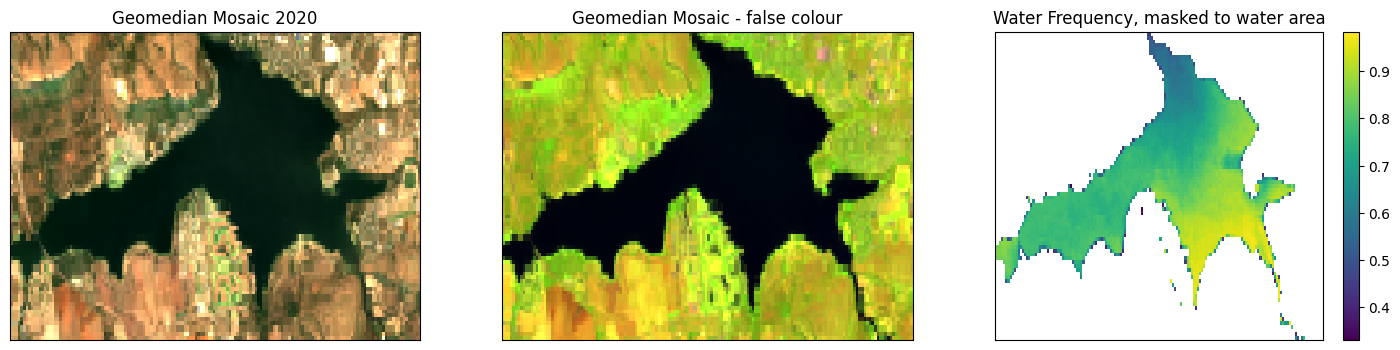

In [23]:
# --- visualise the area ---
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
#ds_annual.water_5yr.mean(dim='time').plot.imshow(ax=ax[2])
(ds_annual.wofs_ann_wetcount.sum(dim='time')/ds_annual.wofs_ann_clearcount.sum(dim='time')).where(ds_annual.water_5yr.mean(dim='time')>0).plot.imshow(ax=ax[2])
#(ds_annual.wofs_ann_wetcount/ds_annual.wofs_ann_clearcount).where(ds_annual.water_5yr>0).mean(dim=('x','y')).plot.step(marker='',color='r',linestyle='-',ax=ax[2])

tindex = int(ds_annual.time.size/2)
if ds_annual.msi_agm[tindex]==True:
    rgb(ds_annual,bands=['msi04_agm','msi03_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[0])
    rgb(ds_annual,bands=['msi11_agm','msi8a_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[1])
else: 
    if ds_annual.oli_agm[tindex]==True:
        print('trying oli')
        rgb(ds_annual,bands=['oli04_agm','oli03_agm','oli02_agm'],index=tindex,index_dim='time',ax=ax[0])
        rgb(ds_annual,bands=['oli06_agm','oli05_agm','oli03_agm'],index=tindex,index_dim='time',ax=ax[1])
    else :
        if ds_annual.tm_agm[tindex]==True: 
           print('trying tm')
           rgb(ds_annual,bands=['tm03_agm','tm02_agm','tm01_agm'],index=tindex,index_dim='time',ax=ax[0])
           rgb(ds_annual,bands=['tm05_agm','tm04_agm','tm02_agm'],index=tindex,index_dim='time',ax=ax[1])
     
# Titles
ax[0].set_title("Geomedian Mosaic "+str(pd.DatetimeIndex(ds_annual.time).year[tindex])), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Geomedian Mosaic - false colour"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
ax[2].set_title("Water Frequency, masked to water area"), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False);
#ax[2].set_title("Water extent mask"), ax[2].xaxis.set_visible(False), ax[2].yaxis.set_visible(False);
#ax[2].set_title("Average water frequency"), ax[2].xaxis.set_visible(True), ax[2].yaxis.set_visible(True);


#### Commentary:
- The false-colour image will tend to highlight areas that are persistently affected by floating weed and algae.
- If algae or water weeds are prevalent the water freqency will often be below 1, even for permanent water areas.
- This is because the water is sometimes 'hidden' beneath the material on the surface. 
- **For example**, If you are looking at the default settings, you are seeing Hartbeespoort Dam. The dam wall, and therefore the deepest part of the lake, is at the northenmost point. Yet in this area the ***water frequency drops well belaw 1*** - due to persistent coverage of water hyacinth.
- **You can see these features clearly on the DE Africa map** : https://maps.digitalearth.africa/#share=s-pcg0S4isI7ZHsdvpQ0wslVswAhG).

#### 2. Calculate the Floating Algal Index for the Geomedian
Firstly, **we set up a function** that will calculate the index for the sensors that we are using.

We then **apply the FAI function** to the annual datasets. 

In [24]:
# --- a function that calculates the FAI
# ------------------------------------------------------------------------------------------------------------------------------------
# FAI algorithm depends on knowledge of the central wavelengths of the red, nir, and swir sensors. We include  a dictionary of those values here to keep the function self-contained
def FAI (ds, instrument, test=False):
    inst_bands = ib = {}
    ib['msi']     = {  'red' : ('msi04',     665),          'nir' : ('msi8a',     864),          'swir': ('msi11',     1612)            }
    ib['msi_agm'] = {  'red' : ('msi04_agm', 665),          'nir' : ('msi8a_agm', 864),          'swir': ('msi11_agm', 1612)            }
    ib['oli']     = {  'red' : ('oli04',    (640 + 670)/2), 'nir' : ('oli05',    (850 + 880)/2), 'swir': ('oli06',    (1570 + 1650)/2)  }
    ib['oli_agm'] = {  'red' : ('oli04_agm',(640 + 670)/2), 'nir' : ('oli05_agm',(850 + 880)/2), 'swir': ('oli06_agm',(1570 + 1650)/2)  }
    ib['tm']      = {  'red' : ('tm03',     (630 + 690)/2), 'nir' : ('tm04',     (760 + 900)/2), 'swir': ('tm05',     (1550 + 1750)/2)  }
    ib['tm_agm']  = {  'red' : ('tm03_agm', (630 + 690)/2), 'nir' : ('tm04_agm', (760 + 900)/2), 'swir': ('tm05_agm', (1550 + 1750)/2)  }
    if not instrument in inst_bands.keys():
        print('! -- invalid instrument, FAI will be calculated as zero --- !')
        return(0)
    red, l_red   = ib[instrument]['red'][0], ib[instrument]['red'] [1]
    nir, l_nir   = ib[instrument]['nir'][0], ib[instrument]['nir'] [1]
    swir,l_swir  = ib[instrument]['swir'][0],ib[instrument]['swir'][1]

    if test: 
        print('red : ',red,l_red)
        print('nir : ',nir,l_nir)
        print('swir: ',swir,l_swir)
        print((l_nir - l_red )/(l_swir-l_red))
            
    # --- final value is scaled by 10000 to reduce to a value typically in the range of 0-1 (this assumes that our data are scaled 0-10,000)     
    return((ds[nir] - ( ds[red] + ( ( ds[swir] - ds[red] ) * ( ( l_nir - l_red ) / ( l_swir - l_red ) ) ) )) / 10000)
# ------------------------------------------------------------------------------------------------------------------------------------


In [58]:
# --- a function to calculate the FAI for the geomedians, also applying the water mask and a threshold.  
#     The FAI function needs to kmow the instrument because the bands used are instrunent-specific
#     Values from different sensors are standardised using mean values developed empirically, with MSI taken as the reference becasue there are more msi data. 

def geomedian_FAI (ds_annual,water_mask,test=False):
    reference_mean = {
        'fai'  : {'msi_agm': 0.0970, 'oli_agm' : 0.1015, 'tm_agm': 0.0962},
        }
    threshold = {
        'fai' : {'msi_agm': 0.05   , 'oli_agm' : 0.05   , 'tm_agm': 0.05},
        }
    if test : print('starting')
    count = 0   
    for inst in list(('msi','oli','tm')):
        inst_agm = inst+'_agm'
        if inst_agm in ds_annual.data_vars: 
            scale = reference_mean['fai']['msi_agm'] / reference_mean['fai'][inst_agm]
            if test: print('\n',inst_agm,scale)

            # --- calculate the FAI for this sensor
            fai_data = FAI(ds_annual,inst_agm,test = False) * scale
            #if test: print('\n',fai_data)

            # --- set nans to zero, and also in the agm_count variable
            fai_data                     = np.where(~np.isnan(fai_data),fai_data,0)
            ds_annual[inst_agm+'_count'] = xr.where(~np.isnan(ds_annual[inst_agm+'_count']),ds_annual[inst_agm+'_count'],0)

            if test: print('\n','fai data : ',fai_data)
            if test: print('\n','agm count: ',ds_annual[inst_agm+'_count'])

            # --- this step must be done before thresholding for the instrument, since that brings in nans
            if count == 0: 
                mean_fai  =  fai_data * ds_annual[inst_agm+'_count']
                agm_count =             ds_annual[inst_agm+'_count']
                if test: print('\n fai and agm count initial',mean_fai,agm_count)  
            else :    
                mean_fai  = mean_fai  + fai_data * ds_annual[inst_agm+'_count']
                agm_count = agm_count + ds_annual[inst_agm+'_count']
                if test: print('\n fai and agm count compounded',mean_fai,agm_count)
            count = count + 1

            # --- trim the fai values back to relevant areas and values
            fai_data = np.where(fai_data > threshold['fai']['msi_agm'],fai_data,np.nan)
            
            # fai_data = np.where(ds_annual.wofs_5yr_freq > WAFT,fai_data,np.nan) 
            fai_data = np.where(~np.isnan(water_mask),fai_data,np.nan)   # new code with mask 

            # --- this retains an fai for each instument, but that is not essential
            ds_annual[inst_agm+'_fai'] = (ds_annual.wofs_ann_freq.dims),fai_data
            if test: print('\n','instrument fai result:',ds_annual[inst_agm+'_fai'])

    # --- divide by the total count to get the actual mean, then trim back to relevant values and areas
    mean_fai = mean_fai / agm_count
    if test: print('\n','agm fai result:',mean_fai)
    mean_fai = np.where(mean_fai > threshold['fai']['msi_agm'] ,mean_fai,np.nan)
    if test: print('\n','agm fai result after thresholding:',mean_fai)
    mean_fai = np.where(~np.isnan(water_mask)               ,mean_fai,np.nan)
    if test: print('\n','agm fai result after water mask:',mean_fai)

    ds_annual['agm_fai'] = (ds_annual.wofs_ann_freq.dims), mean_fai

    return(ds_annual)


In [26]:
# --- run the FAI function for all pixels, 
ds_annual = geomedian_FAI(ds_annual,ds_annual.water_5yr)
ds_annual['fai_cover'] = \
        ('time'), \
        ((ds_annual.agm_fai.count(dim=('x','y'))  / ds_annual.water_5yr.count(dim=('x','y'))) \
         *100).round(2).data

# -- and save the percentage area affected in the results

annual_results = results['annual_results']
newcolname = 'fai_cover_percent'
if newcolname in annual_results.columns:  annual_results = annual_results.drop(labels=[newcolname],axis=1)
annual_results.insert(annual_results.columns.size,
                      newcolname,
                        ((ds_annual.fai_cover))
                     )
results['annual_results'] = annual_results


### Annual Results:
The geomedian analysis shows the patterns of affected area on an annual basis.

It calculates the proportion of the area that was ***persistently affected*** each year, 
that is, the amount of area where high FAI values were ***"normal"*** for the year.

In [59]:
#annual_results = annual_results.drop(labels = ['percent_affected'],axis=1)
results['annual_results'][['year','area_km2','fai_cover_percent']]


,year,area_km2,fai_cover_percent
0,2016,17.14,0.37
1,2017,17.14,13.55
2,2018,17.14,8.52
3,2019,16.96,15.71
4,2020,17.03,1.90
5,2021,17.11,4.38
6,2022,17.25,7.53
7,2023,17.25,2.27
8,2024,17.25,2.33


##### Note:
- ***area_km2*** is the area that we consider to be water, in units of square kilometers. This is calculated over a 5 year interval.
- ***fai_cover_percent*** is the percentage of the water area that was affected by algae (cyanobacteria) or floating vegetation such as water hyacinth. Since we are working from an annual median, these are the areas that were ***consistently affected***. This is therefore a conservative statistic. We can be confident that we are not over-stating the problem, or reporting on transient events.

In [60]:
#display the results from the geomedian analysis

# we want the time series data to display nicely as a step plot centred on the calendar year. This requires that we pad out the data, which is painful

In [61]:
# --- a function to make nice step-plot data; we assume that we're working with time data and that the step intervals are even
def make_stepplot_data(tdata,ydata):
    delta = ((np.datetime64(tdata[1])- np.datetime64(tdata[0]))/2)
    steps = np.array([], dtype='datetime64')
    values = []
    for t in tdata:
        value  = ydata[tdata==t]
        tminus = t - delta
        tplus  = t + delta
        steps  = np.append(steps, [tminus,tplus])
        values = np.append(values,[value ,value])
    return(steps,values)    

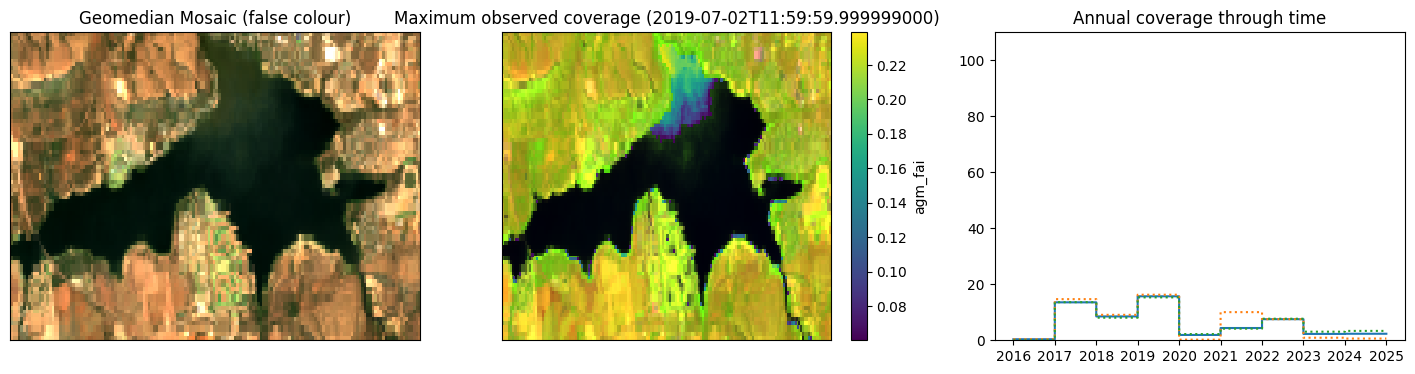

In [62]:
#--- plot the annual results!
max_year    = annual_results[annual_results.fai_cover_percent == annual_results.fai_cover_percent.max()].time.values[0]
max_year_index = list(annual_results.time).index(max_year)

fig, ax = plt.subplots(1, 3, figsize=(18, 4))

ax[2].set_ylim(0,110)

tindex = max_year_index
if ds_annual.msi_agm[tindex]==True:
    rgb(ds_annual,bands=['msi04_agm','msi03_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[0])
    rgb(ds_annual,bands=['msi11_agm','msi8a_agm','msi02_agm'],index=tindex,index_dim='time',ax=ax[1])
else: 
    if ds_annual.oli_agm[tindex]==True:
        print('trying oli')
        rgb(ds_annual,bands=['oli04_agm','oli03_agm','oli02_agm'],index=tindex,index_dim='time',ax=ax[0])
        rgb(ds_annual,bands=['oli06_agm','oli05_agm','oli03_agm'],index=tindex,index_dim='time',ax=ax[1])
    else :
        if ds_annual.tm_agm[tindex]==True: 
           rgb(ds_annual,bands=['tm03_agm','tm02_agm','tm01_agm'],index=tindex,index_dim='time',ax=ax[0])
           rgb(ds_annual,bands=['tm05_agm','tm04_agm','tm02_agm'],index=tindex,index_dim='time',ax=ax[1])

ds_annual.sel(time=str(max_year)).agm_fai.plot(ax=ax[1])

t,y = make_stepplot_data(annual_results.time,annual_results.fai_cover_percent)
plt.plot(t,y,label='all data')

for instrument in 'oli_agm','msi_agm','tm_agm':
    if instrument in ds_annual.data_vars:
        y   = (((ds_annual[instrument+'_fai'].count(dim=('x','y')) * parameters['cell_area']) / annual_results.area_km2) * 100).round(2)
        t,y = make_stepplot_data(np.asarray(ds_annual.time),y)
        plt.plot(t,y,linestyle=':',label=instrument)

# Titles
ax[0].set_title("Geomedian Mosaic (false colour)"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("Maximum observed coverage ("+str(max_year)+")"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
ax[2].set_title("Annual coverage through time"), ax[2].xaxis.set_visible(True), ax[2].yaxis.set_visible(True);

#### Commentary:
- The graph shows the coverage based on all available geomedians (OLI, TM, MSI).
- Results from each geomedian appear as dotted graphs.
- The step function is used to indicate that these results are based on the entire year, not a point in time.
- When combining OLI and MSI geomedians, the number of clear observations of each pixel is used as a weight.
- The percent cover is the percentage of area that is ***normally affected** during the year. E.g., *In 2022, there was 30% of the lake that typically had weed cover* . We would expect this to be **less than the mean area affected**, i.e, a conservative measure.
- The geomedian results are quick to produce and indicate relative changes through time. However the *absolute values* are difficult to interpret and are sensitive to the threhold used to decide which FAI values are 'significant'. To 'calibrate' the geomedian results they need to be compared to the daily observations, which is the next part of this notebook. 

### Export results to a file
At this point, we can save the annual results to text and csv files.

In [31]:
# --- the parameters used in the analysis are saved as a simple text file
basefilename = parameters['placename']+'_'+parameters['xyt']['time'][0]+'_'+parameters['xyt']['time'][1]
filename     = basefilename+'.txt'
with open(filename, 'w') as f:
  f.write(str(parameters))
    
# --- annual and daily files are easily saved as csv files
filename = basefilename+'_annual.csv'
results['annual_results'].to_csv(filename)

## A detailed study using *all available observations*

Working with the daily observations introduces more information, and more complexity:
- Several minutes are needed to access the data, and more memory is needed
- Datasets from each satellite / sensor must be combined to produce a single dataset

Challenges:
- Each sensor has it's own band names - we introduce **standardised variable names**, and re-name the bands, eg. ***oli01***
- We need to remember which sensor was used at each capture time - we add a boolean variable for each sensor, '*oli*, *msi*, *tm*)
- Individual images and pixels must be filtered for data quality - we add a ***qa_score*** variable, which must be greater than zero
- Some images are incomplete, covering only part of the water area - we add a ***coverage_percent*** variable) 
- Results typically need to be averaged over a number of observations to smooth out the noise'
- Validation - we can compare the results for Hartbeespoort dam in South Africa with published material for some years to get confidence in our results!


In [32]:
# --- A function to build the time-series / indivitual time-slices dataset ---

def build_time_series(parameters, test = True):
    _instruments_to_use = {
        'oli_agm'  : {'use': False },
        'oli'      : {'use': True},
        'msi_agm'  : {'use': False },
        'msi'      : {'use': True},
        'tm_agm'   : {'use': False },
        'tm'       : {'use': True},
        'tirs'     : {'use': False},  
        'wofs_ann' : {'use': False },
        'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
        }
    instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

    y1 = pd.DatetimeIndex([str(parameters['xyt']['time'][0])]).year[0]
    y2 = pd.DatetimeIndex([str(parameters['xyt']['time'][1])]).year[0]
    check_instrument_dates(instruments_to_use,y1,y2,False)
    products = { 
                'tm_agm'  :["gm_ls5_ls7_annual"],
                'tm'      :["ls5_sr","ls7_sr"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'oli'     :["ls8_sr","ls9_sr"],
                'msi_agm' :["gm_s2_annual"],
                'msi'     :["s2_l2a"],
                'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }
    instruments,measurements,rename_dict = instruments_list(instruments_to_use) 
    
    data_list = {}

    if instruments_to_use['oli']['use']:
        print('building the oli (Operational Land Imager, Landsat 8, 9)  dataset...')
        instrument = 'oli'
        # --- load oli data
        # Load available data from all three Landsat satellites
        print('... loading data ...')
        
        ds_oli = dc.load(product=(products[instrument]),
                                 **parameters['xyt'],
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=parameters['grid_resolution'],
                                 align=(0,0),
                                 resampling=parameters['resampling_option'],)
        # --- re-name the variables for the sake of sanity --- 
        ds_oli = rename_vars_robust(ds_oli,rename_dict['oli'])
        # --- set zeros to nans and re-scale 
        for var in ds_oli.data_vars:
            if not var == 'oli_qa':
                ds_oli[var] = xr.where(ds_oli[var]>=0,ds_oli[var],np.nan)
                ds_oli[var] = ((ds_oli[var] * 0.0000275) - 0.2) * 10000

        data_list['oli'] = ds_oli
        print('... done.')

    if instruments_to_use['msi']['use']:
        print('building the msi (Multi Spectral Imager, Sentinel 2) dataset....')
        instrument = 'msi'
        test = True
        # --- load msi data
        print('... loading data ...')
        ds_msi = dc.load(product=(products[instrument]),
                                 **parameters['xyt'],
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=parameters['grid_resolution'],
                                 align=(0,0),
                                 resampling=parameters['resampling_option'],)
        # --- re-name the variables for the sake of sanity --- 
        ds_msi = rename_vars_robust(ds_msi,rename_dict['msi'])
        # --- set zeros to nans and re-scale 
        for var in ds_msi.data_vars:
            if not var == 'msi_qa':
                ds_msi[var] = xr.where(ds_msi[var]>=0,ds_msi[var],np.nan)
                ds_msi[var] = ds_msi[var] #- 1000  # offset required for variables other than the pq ??
        

        data_list['msi'] = ds_msi
        print('... done.')
    

    if instruments_to_use['tm']['use']:
        print('building the tm ((enhanced) Thematic Mapper, Landsat 5, 7)  dataset ...')
        instrument = 'tm'
        # --- load tm data
        print('... loading data ...')
        ds_tm = dc.load(product=(products[instrument]),
                                 **parameters['xyt'],
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=parameters['grid_resolution'],
                                 align=(0,0),
                                 resampling=parameters['resampling_option'],)

        # --- re-name the variables for the sake of sanity --- 
        ds_tm = rename_vars_robust(ds_tm,rename_dict['tm'])
    

        # --- set zeros to nans and re-scale 
        for var in ds_tm.data_vars:
            if not var == 'tm_qa':
                ds_tm[var] = xr.where(ds_tm[var]>=0,ds_tm[var],np.nan)
                ds_tm[var] = ((ds_tm[var] * 0.0000275) - 0.2) * 10000

        data_list['tm'] = ds_tm
        print('... done.')
    
    return(data_list)

In [33]:
# --- Build the datasets (have a coffee while this is running) ---
print('\n------------------------------------------------------------------------------------------------\n')
print('Now is a good time to have a break! It will take some time (tens of minutes) to build the dataset.')
print('\n--------------------------------------------------------------------------------------------------')
data_list = build_time_series(parameters,True)
print('\n------------------------------------------------------------------------------------------------\n')
print('Completed')
print('\n--------------------------------------------------------------------------------------------------')



------------------------------------------------------------------------------------------------

Now is a good time to have a break! It will take some time (tens of minutes) to build the dataset.

--------------------------------------------------------------------------------------------------
building the oli (Operational Land Imager, Landsat 8, 9)  dataset...
... loading data ...
... done.
building the msi (Multi Spectral Imager, Sentinel 2) dataset....
... loading data ...
... done.
building the tm ((enhanced) Thematic Mapper, Landsat 5, 7)  dataset ...
... loading data ...
... done.

------------------------------------------------------------------------------------------------

Completed

--------------------------------------------------------------------------------------------------


### Whew! 
### Now to take steps to combine the data from multiple instruments (oli,msi,tm) into a single dataset ...
We add a boolean variable and a qa_score for each variable before combining to a single dataset

In [45]:
# --- a function that adds boolean variables that retain the source instrument, and a qa_score variable. 
def add_vars_and_combine_datasets(data_list):
    # --- setting qa_score to nan, 0 or 1
    for instrument in data_list.keys():
        # --- select the relevant dataset ---
        ds        = data_list[instrument]
        ds[instrument] = ('time'), np.ones(ds.time.sizes['time']).astype('bool')                    # --- a boolean variable with a value of 'True' ---
        ds['qa_score'] = ('time','y','x'), np.zeros([ds.sizes['time'],ds.sizes['y'],ds.sizes['x']]) # --- a "qa_score" variable and set to zero ----

        # --- attempt to set the value of the qa_score, based on the pixel quality data provided with the data.  
        if instrument == 'tm':  
            ds['qa_score'] = ds.tm_qa * ds.qa_score   # --- sets the qa_score to nan where there is nodata (should not happen)
            ds['qa_score'] = xr.where(np.isin(ds.tm_qa,[5504,5440]),1,ds.qa_score) #DEA mess around with the pixel values so that they sort of conform to OPI, but not really.
            ds['qa_score'] = xr.where(ds.tm_qa==1 , np.nan , ds.qa_score) #values of 1 are 'fill', set to nan

        if instrument == 'oli': 
            ds['qa_score'] = ds.oli_qa * ds.qa_score   # --- sets the qa_score to nan where there is no coverage
            ds['qa_score'] = xr.where(ds.oli_qa<=21952 , 1 , ds.qa_score) 
            ds['qa_score'] = xr.where(ds.oli_qa==1 , np.nan , ds.qa_score) #values of 1 are 'fill', set to nan
            # oli qa scores are found here : https://www.usgs.gov/landsat-missions/landsat-collection-2-quality-assessment-bands
            # 21952 corresponds to a clear pixel over water. This is the base for use here.

        if instrument == 'msi': 
            ds['qa_score'] = ds.msi_qa * ds.qa_score   # --- sets the qa_score to nan where there is no coverage (should not happen)
            ds['qa_score'] = xr.where(ds.msi_qa < 7,1,ds.qa_score)
            ds['qa_score'] = xr.where(ds.msi_qa==1 , np.nan , ds.qa_score) #values of 1 are 'fill', set to nan

            
    # --- now combine all the instrument datasets to a single dataset ---
    first = True
    for name in data_list.keys():
        if first:
            full_ds    = data_list[name]
            first = False
        else:
            full_ds = full_ds.combine_first(data_list[name])
    return(full_ds)

In [46]:
# --- add variables and make a single dataset from the instrument datasets ---
ds = add_vars_and_combine_datasets(data_list)

# --- we don't need the individual datasets any more; we can tidy up to save memory 
#for name in data_list.keys():

    #del name
gc.collect()

9310

#### Apply a water mask and determine the coverage and quality of each image
- We choose the water mask for the year at the core of the time series

In [47]:
# --- calculate the water_pixel_count (over water areas), the coveragepercent (over water areas), and the qapasspercent (of available data over water areas) for each observation 

year      = pd.DatetimeIndex(ds['time']).year[int(ds.time.size/2)]  # the year at the centre of the monitoring interval
water_5yr = ds_annual.water_5yr.sel(time=str(year)).squeeze()       # a data array with xy shape
water_pixel_count = water_5yr.count()

# --- calculate the proportion of observations that are present and valid, at each time-step
ds['data_coverage']   =  (ds.where(~np.isnan(ds.qa_score)).where(water_5yr == 1).qa_score.count(dim=('x','y'))/water_pixel_count)

# --- calculate the proportion of valid observations that pass QA
ds['data_qapass']     =  (ds.where(ds.qa_score >0)        .where(water_5yr == 1).qa_score.count(dim=('x','y'))/water_pixel_count)

# --- save the water pixel count as a variable in the dataset ...
ds['water_pixel_count'] = water_pixel_count

#### Drop dates (i.e. images) for dates when the coverage of good data is low
- images that are more than mostly cloudy are less useful when producing average statistics for the waterbody.
- dropping pood quality dates reduces the size of the dataset

In [48]:
# --- remove observations (dates) that have poor qa passpercent and/or coverage. This will reduce the dataset but ironically causes a memory blip.
qa_threshold = .2   # --- i.e., accept observations where > 20% of the water area has good data
ds = ds.where(ds['data_qapass'] > qa_threshold,drop=True)
gc.collect()

0

#### Calculate the per-pixel FAI and apply a threshold
- we already have an FAI function that we can use for this, however there is some housekeeping to do

In [49]:
# --- a function that calculates the FAI for each sensor, restricting to water areas

def calc_fai(ds,watermask,threshold = 0.0):
    ds['fai'] = ('time','y','x'),np.zeros([ds.qa_score.sizes['time'],ds.qa_score.sizes['y'],ds.qa_score.sizes['x']])*np.nan
    if 'tm'  in ds.data_vars:    
        ds['fai'].loc[ds.tm ==True] = FAI(ds.where(ds.fai.loc[ds.tm== True]),'tm' )
    if 'oli' in ds.data_vars:    
        ds['fai'].loc[ds.oli==True] = FAI(ds.where(ds.fai.loc[ds.oli==True]),'oli')
    if 'msi' in ds.data_vars:    
        ds['fai'].loc[ds.msi==True] = FAI(ds.where(ds.msi.loc[ds.msi==True]),'msi')

    ds['fai'] = ds.fai.where(ds.fai > threshold).where(watermask==1).where(ds.qa_score >0) 
    return(ds)

In [50]:
# --- run the functions above ---
ds = calc_fai(ds,water_5yr)   

### Calculate the percentage cover
- divide the number of pixels where the FAI is high (above a threshold of 0.1), by the water area.
- we have to also allow for missing data, such as gaps in ETM data, or cloud cover.

The threshold of 0.1 is conservative; FAI over this are very unlikely to be 'noise'. 
- with a conservative threshold, we can be confident that we are **not over-estimating** the affected area.
- results are not very sensitive to the threshold; values between 0.05 and 0.1 will give similar results.

As well as cloud affecting the imagery,floating weeds and algae can move and change rapidly. We can smooth the data over several observations to better reveal systematic changes.

In [65]:
# --- calculate the percentage of the water area that shows high fai values
t = 0.1
fai_percent_cover = \
    100 * \
    (ds.where(ds.qa_score>0).where(water_5yr==1).where(ds.fai>t).fai.count(dim=('x','y'))) / \
    (ds.where(ds.qa_score>0).where(water_5yr==1).           qa_score.count(dim=('x','y'))) 


In [66]:
# --- capture the results into our results dataframe
daily_results = pd.DataFrame(
    {
        'time': pd.DatetimeIndex(ds.time),
        'year': pd.DatetimeIndex(ds.time).year,
        'month': pd.DatetimeIndex(ds.time).month,
        'day': pd.DatetimeIndex(ds.time).day,
        'sensor': '',
    })     
for instrument in 'oli','msi','tm':
    if instrument in ds.data_vars:
        daily_results['sensor'] = np.where(ds[instrument]==True,instrument,daily_results.sensor)    

daily_results.insert(daily_results.columns.size,'qa_pass_percent',(ds.data_qapass*100).round(1))
daily_results.insert(daily_results.columns.size,'fai_cover',fai_percent_cover.round(1))
results['daily_results'] = daily_results

In [67]:
# --- a function to compute a moving average of a 1-d series without losing data at the ends 
def moving_average(a, n=3, reflect = True):
    if np.mod(n,2)==0: n = n + 1  # ensures the window is an odd number
    if reflect :
        N = int(n/2)
        s = a.size
        a = np.hstack((a[N:0:-1],a,a[s-2:s-N-2:-1]))
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

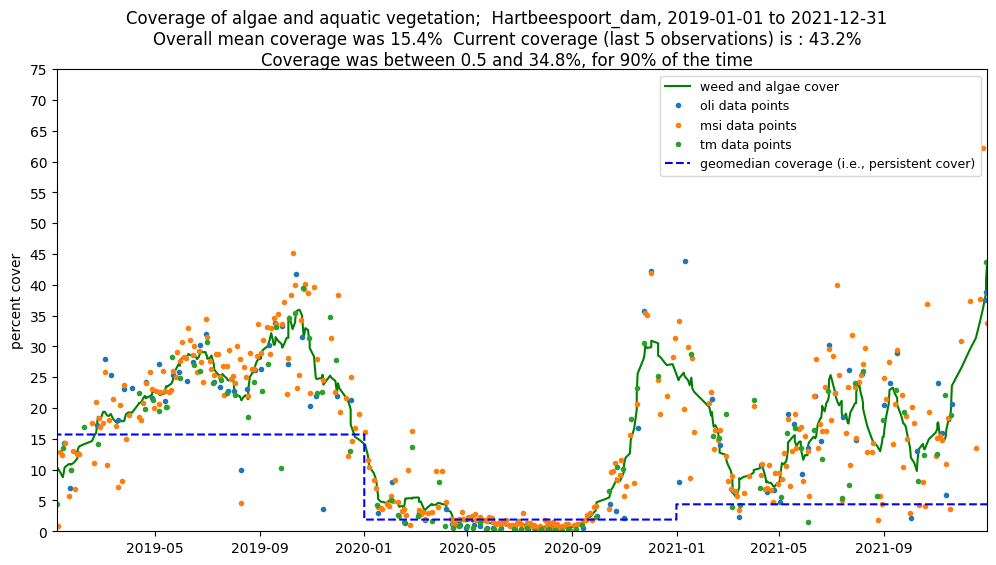

In [68]:

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(daily_results[daily_results.fai_cover>=0].time.values,moving_average(daily_results[daily_results.fai_cover>=0].fai_cover.values,10),
        color='g',linestyle='-',label='weed and algae cover')

for instrument in 'oli','msi','tm':
    if instrument in ds.data_vars:    
        ax.plot(daily_results.time.where(daily_results.sensor==instrument),
                 daily_results.fai_cover.where(daily_results.sensor==instrument),
                linestyle='',marker='.',label=instrument+' data points')
t,y = make_stepplot_data(results['annual_results'].time,annual_results.fai_cover_percent)
ax.plot(t,y,color='b',linestyle='--',marker='',label='geomedian coverage (i.e., persistent cover)')

ax.set(xlim=(daily_results.time.min(),daily_results.time.max()),
       ylim=(0,60),yticks=np.arange(0,80,5),ylabel='percent cover')
ax.legend(fontsize=9)

data = results['daily_results']
pc05 = data.fai_cover.quantile(.05).round(1)
pc95 = data.fai_cover.quantile(.95).round(1)
overallmean = data.fai_cover[:].mean().round(1)
last_5_obs = data.fai_cover[-5:].mean().round(1)
narrative = \
            '\nOverall mean coverage was '+str(overallmean)+'%  Current coverage (last 5 observations) is : '+str(last_5_obs)+'%'+\
            '\nCoverage was between '+str(pc05)+' and '+str(pc95)+'%, for 90% of the time'
            
plt.suptitle('Coverage of algae and aquatic vegetation;  '+parameters['placename']+', '+
            parameters['xyt']['time'][0]+' to '+parameters['xyt']['time'][1]+narrative)

plt.show()

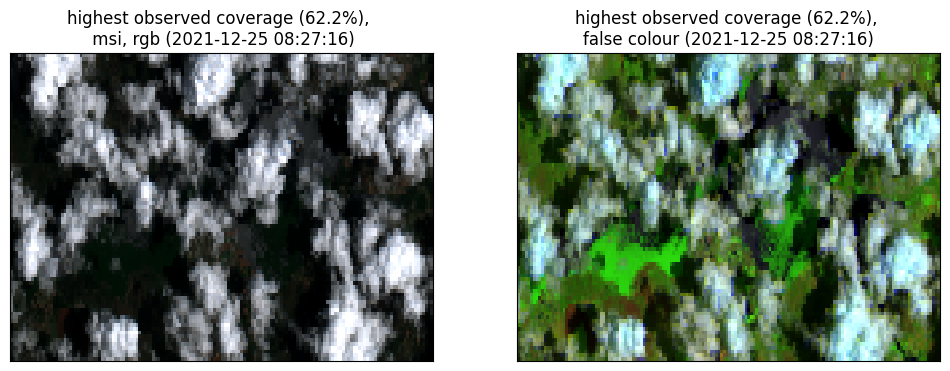

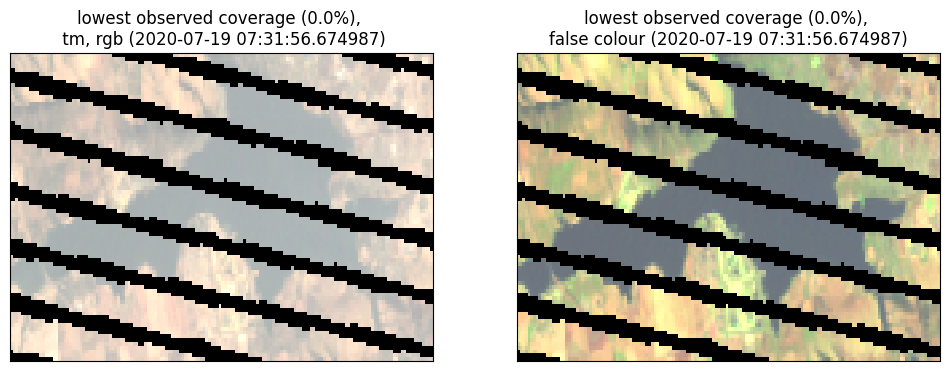

<function matplotlib.pyplot.show(close=None, block=None)>

In [57]:
data = results['daily_results']
low_value   = data.fai_cover.min()
high_value  = data.fai_cover.max()
low_index   = data[data.fai_cover==low_value ].index[0]
high_index  = data[data.fai_cover==high_value].index[0]
low_time    = data.time  [low_index]
high_time   = data.time  [high_index]
low_sensor  = data.sensor[low_index]
high_sensor = data.sensor[high_index]

rgbnirswir = {}
rgbnirswir['msi'] = {'rgb': ('msi04','msi03','msi02'), 'sng':('msi11','msi8a','msi03')}
rgbnirswir['oli'] = {'rgb':('oli04','oli03','oli02') , 'sng':('oli06','oli05','oli03')}
rgbnirswir['tm']  = {'rgb':('tm03' ,'tm02' , 'tm01'),  'sng':('tm05','tm04','tm02') }

fig, ax = plt.subplots (1,2, figsize=(12, 4))

rgbbands    = rgbnirswir[high_sensor]['rgb']
rgb(ds,bands=[rgbbands[0],rgbbands[1],rgbbands[2]],index=high_index,index_dim='time',ax=ax[0])
rgbbands    = rgbnirswir[high_sensor]['sng']
rgb(ds,bands=[rgbbands[0],rgbbands[1],rgbbands[2]],index=high_index,index_dim='time',ax=ax[1])

# Titles
ax[0].set_title("highest observed coverage ("+str(high_value)+"%), \n "+high_sensor+", rgb ("+str(high_time)+")"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("highest observed coverage ("+str(high_value)+"%), \nfalse colour ("+str(high_time)+")"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
plt.show()

fig, ax = plt.subplots (1,2, figsize=(12, 4))

rgbbands = rgbnirswir[low_sensor]['rgb']
rgb(ds,bands=[rgbbands[0],rgbbands[1],rgbbands[2]],index=low_index,index_dim='time',ax=ax[0])
rgbbands = rgbnirswir[low_sensor]['sng']
rgb(ds,bands=[rgbbands[0],rgbbands[1],rgbbands[2]],index=low_index,index_dim='time',ax=ax[1])

ax[0].set_title("lowest observed coverage ("+str(low_value)+"%), \n "+low_sensor+", rgb ("+str(low_time)+")"), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title("lowest observed coverage ("+str(low_value)+"%), \nfalse colour ("+str(low_time)+")"), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False);
plt.show()

plt.show

### Results
- As well as the overall results, **we can check at this point that we are not seeing differences between sensors**. If differences were apparent, we would want to adjust one sensor to match the others.
  
- With the default settings - Hartbeespoort dam in South Africa - you may see that on 2024-01-04 both landsat (oli) and sentinel-2 (msi) captured data. Both instruments produced an estimated coverage of 31% at that time. This gives some confidence that the methods are working!

  
- A second approach to validating the results is to examine images of specific dates in the DE Africa map:
   **For the default setting of Hartbeespoort Dam this link shows the coverage at 2025-10-15:** https://maps.digitalearth.africa/#share=s-aGgNgwMuNyV1XIj5ja69I5jVyW9

  
- Examining the map also shows that during high coverage periods there is also often high cloud, leading to higher variance in the estimated areas (since we estimate the percentage coverage based on the area that we can see). This produces scatter in the graph.

- Finally, results can also be compared with published data on this dam - **see following panel** 
  
We should also compare the 'daily' results with the results from the annual geomedian analysis. 
- The Geomedian indicates the percentage of area that was **consistently affected throughout the year** and is a conservative statistic.
- We expect it to be less than the mean coverage, but in the same ball-park.
- The geomedian values **will indicate *year on year changes in severity***, but will be less reliable pre-2013.

### Comparison with external results
The graph below compares findings from these methods with results published by rosali.moffat@fabi.up.ac.za, https://www.sciencedirect.com/science/article/pii/S1049964424001099.

The results are very consistent some areas, however we detect material at times (in 2021 and 2022) when the authors report low coverage. 
- Examination of imagery on the DE Africa map confirms that photsynthetic material was certaily present at these times, e.g.:
 **2022-09-06, which you can see here**: https://maps.digitalearth.africa/#share=s-dXe6dhdEBnp6IDQoOsUFKkIVXIJ

The most likely explanation for this is that the authors went one step further, to separate *algal blooms* from water hyacinth. In this workbook **we do NOT separate out floating algae from vegetation** - both give a high FAI. 

Importantly, **the magnitude of the coverage is consistent**, giving us confidence that our methods are effective and accurate. 


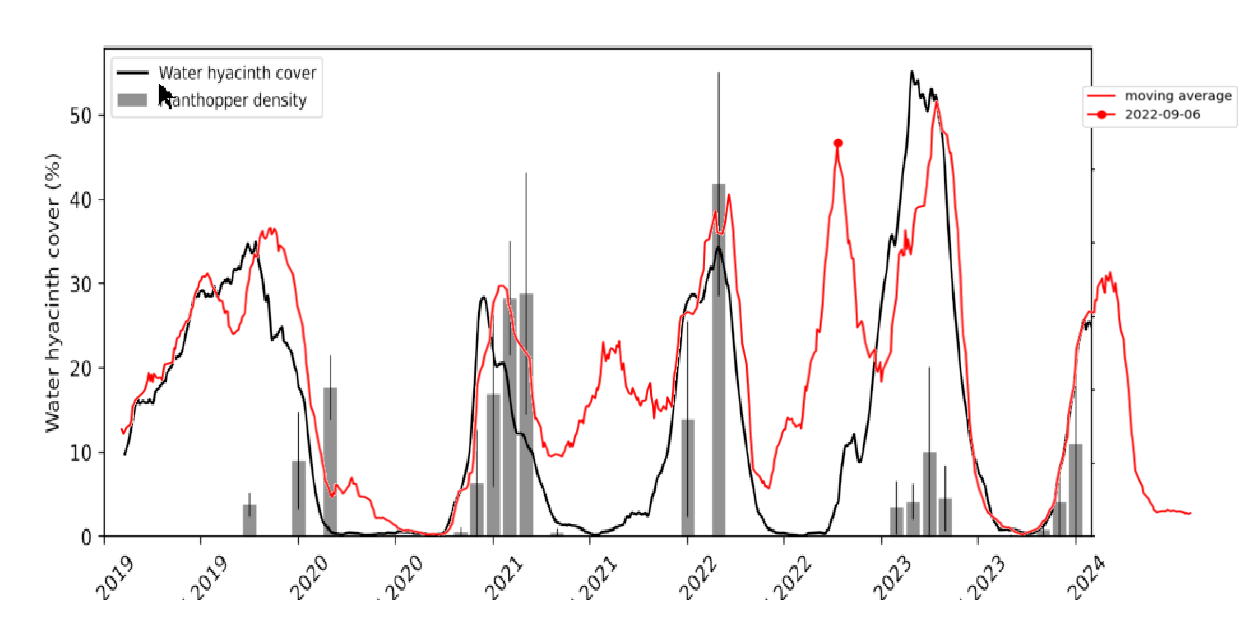

### Export results to a file
At this point, we can save all the remaining results to text and csv files!

In [430]:
# --- the detailed data is saved as a csv file 
filename = basefilename+'_daily.csv'
results['daily_results'].to_csv(filename)

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [23]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [1449]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-11-03'